In [114]:
# stdlib
import os
import sys

# auton-survival
from auton_survival.models.dsm import DeepRecurrentSurvivalMachines

# synthcity absolute
from synthcity.utils.datasets.time_series.pbc import PBCDataloader
from synthcity.plugins.core.dataloader import TimeSeriesSurvivalDataLoader

# third party
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc


In [237]:
MODEL_OUTPUT_PATH = "../models/drsm_pbc_model.pkl"
MODEL_SYNTH_OUTPUT_PATH = "../models/drsm_pbc_synthetic_model.pkl"
SYNTHETIC_DATA_PATH = "../data/pbc_synthetic/synthetic_pbc_data.csv"
SYNTHETIC_DATA_PATH_WITH_TIMES = "../data/pbc_synthetic/synthetic_pbc_data_with_times.csv"
K = 4
DISTRIBUTION = "Weibull"
LAYERS = 1
HIDDEN = 50
TYPE ="RNN"
LR = 0.001
TRAIN_ID_CUTOFF = 219
VAL_ID_CUTOFF = 250
TEST_ID_CUTOFF = 312
TRAIN_SYNTH_ID_CUTOFF = 450
VAL_SYNTH_ID_CUTOFF = 500

In [92]:
def get_pbc_data_loader():
    (
        static_surv,
        temporal_surv,
        temporal_surv_horizons,
        outcome_surv,
    ) = PBCDataloader().load()
    T, E = outcome_surv

    static_surv_extended = static_surv.copy()

    drug_values = []
    age_values = []

    for patient_df in temporal_surv:
        drug_values.append(patient_df["drug"].iloc[0])
        age_values.append(patient_df["age"].iloc[0])

    static_surv_extended["drug"] = drug_values
    static_surv_extended["age"] = age_values

    for i in range(len(temporal_surv)):
        temporal_surv[i] = temporal_surv[i].drop(columns=["drug", "age"])

    horizons = [0.25, 0.5, 0.75]
    time_horizons = np.quantile(T, horizons).tolist()

    loader = TimeSeriesSurvivalDataLoader(
        temporal_data=temporal_surv,
        observation_times=temporal_surv_horizons,
        static_data=static_surv_extended,
        T=T,
        E=E,
        time_horizons=time_horizons,
    )

    return loader, time_horizons

In [ ]:
def split_pbc_panel_format(loader, df=None):
    df = loader.dataframe()

    train_ids = list(range(0, TRAIN_ID_CUTOFF))
    val_ids   = list(range(TRAIN_ID_CUTOFF, VAL_ID_CUTOFF))
    test_ids  = list(range(VAL_ID_CUTOFF, TEST_ID_CUTOFF))

    def extract_numpy_sequences(df, id_list):
        x_list, t_list, e_list = [], [], []

        for pid in id_list:
            df_patient = df[df["seq_id"] == pid].copy()

            x_arr = df_patient.drop(columns=["seq_out_time_to_event", "seq_out_event", "seq_id"]).values
            t_arr = df_patient["seq_out_time_to_event"].values
            e_arr = df_patient["seq_out_event"].values

            x_list.append(x_arr)
            t_list.append(t_arr)
            e_list.append(e_arr)

        return (np.array(x_list, dtype=object),
                np.array(t_list, dtype=object),
                np.array(e_list, dtype=object))

    x_train, t_train, e_train = extract_numpy_sequences(df, train_ids)
    x_val,   t_val,   e_val   = extract_numpy_sequences(df, val_ids)
    x_test,  t_test,  e_test  = extract_numpy_sequences(df, test_ids)

    return (x_train, t_train, e_train), (x_val, t_val, e_val), (x_test, t_test, e_test)


def split_pbc_flat_dataframe(loader):
    df = loader.dataframe()

    # Define patient ID splits
    train_ids = list(range(0, TRAIN_ID_CUTOFF))
    val_ids   = list(range(TRAIN_ID_CUTOFF, VAL_ID_CUTOFF))
    test_ids  = list(range(VAL_ID_CUTOFF, TEST_ID_CUTOFF))

    # Subset dataframe by patient ID
    df_train = df[df["seq_id"].isin(train_ids)].copy()
    df_val   = df[df["seq_id"].isin(val_ids)].copy()
    df_test  = df[df["seq_id"].isin(test_ids)].copy()

    # Input features (flattened)
    X_train = df_train.drop(columns=["seq_out_time_to_event", "seq_out_event"]).values
    X_val   = df_val.drop(columns=["seq_out_time_to_event", "seq_out_event"]).values
    X_test  = df_test.drop(columns=["seq_out_time_to_event", "seq_out_event"]).values

    # Output labels (flattened)
    T_train = df_train["seq_out_time_to_event"].values
    E_train = df_train["seq_out_event"].values

    T_val = df_val["seq_out_time_to_event"].values
    E_val = df_val["seq_out_event"].values

    T_test = df_test["seq_out_time_to_event"].values
    E_test = df_test["seq_out_event"].values

    return (X_train, T_train, E_train), (X_val, T_val, E_val), (X_test, T_test, E_test)

In [122]:
loader, time_horizons = get_pbc_data_loader()
(x_train, t_train, e_train), (x_val, t_val, e_val), (x_test, t_test, e_test) = split_pbc_panel_format(loader)

if os.path.exists(MODEL_OUTPUT_PATH):
    print(f"Loading model from {MODEL_OUTPUT_PATH}")
    with open(MODEL_OUTPUT_PATH, "rb") as f:
        drsm_model = pickle.load(f)
else:
    print("Training new timegan model...")
    drsm_model = DeepRecurrentSurvivalMachines(k = K,
                                 distribution = DISTRIBUTION,
                                 hidden = HIDDEN, 
                                 typ = TYPE,
                                 layers = LAYERS)
    
    drsm_model.fit(x_train, t_train, e_train, iters = 1, learning_rate = LR)
    nll = drsm_model.compute_nll(x_val, t_val, e_val)
    print(f"Validation NLL: {nll}")
    with open(MODEL_OUTPUT_PATH, "wb") as f:
        pickle.dump(drsm_model, f)
    print(f"Model saved to {MODEL_OUTPUT_PATH}")

Training new timegan model...


100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


Validation NLL: 0.6725038399585914
Model saved to ../models/drsm_pbc_model.pkl


In [288]:
horizons = [0.25, 0.5, 0.75]
test_time_horizons = np.quantile([t_[-1] for t_, e_ in zip(t_test, e_test) if e_[-1] == 1], horizons).tolist()
out_risk = drsm_model.predict_risk(x_test, test_time_horizons)
out_survival = drsm_model.predict_survival(x_test, test_time_horizons)

cis = []
brs = []

et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i][j], t_val[i][j]) for i in range(len(e_val)) for j in range(len(e_val[i]))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(test_time_horizons):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, test_time_horizons)[1])
brs_2 = brier_score(et_train, et_test, out_survival, test_time_horizons)[1]
roc_auc = []
for i, _ in enumerate(test_time_horizons):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")
print("Brier Score 2:", brs_2[0])

For 0.25 quantile,
TD Concordance Index: 0.6196172248803827
Brier Score: 0.05091750489821231
ROC AUC  0.657258064516129 

For 0.5 quantile,
TD Concordance Index: 0.37532732033750366
Brier Score: 0.08773309190870751
ROC AUC  0.38527777777777783 

For 0.75 quantile,
TD Concordance Index: 0.3929885306210777
Brier Score: 0.12639606046566643
ROC AUC  0.3833398361295357 

Brier Score 2: 0.05091750489821231


In [180]:
def plot_survival_and_pdf(model, patient_data, patient_times, time_points, patient_num=None, risk=1):
    if not model.fitted:
        raise Exception("Model has not been fitted. Please train the model before using this function.")

    time_points = time_points[1:]

    # Predict survival probabilities and PDF
    survival_probabilities = model.predict_survival(patient_data, time_points)
    pdf_values = model.predict_pdf(patient_data, time_points)
    print(pdf_values.shape)
    mean_numerical = calculate_mean_time(pdf_values, time_points)
    mean_theoretical = model.predict_mean(patient_data)
    
    print('-'*50)
    print(f'Showing survival function and PDF for patient {patient_num}' if not patient_num is None else 'Showing survival function and PDF for patient')
    print(f'Mean time to survival (numerical): {mean_numerical}, (theoretical) {mean_theoretical}')
    print(f'True times {(patient_times)}')
    print('-'*50)
    
    # Create plots
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, survival_probabilities[0], label="Survival Function", color="green")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.title(f"Survival Function for Patient {patient_num}" if not patient_num is None else "Survival Function for Patient")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, pdf_values[0], label="Probability Density Function (PDF)", color="blue")
    plt.xlabel("Time")
    plt.ylabel("Probability Density")
    plt.title(f"Probability Density Function for Patient {patient_num}" if not patient_num is None else "Probability Density Function for Patient")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def calculate_mean_time(pdf, times):
    if not isinstance(times, np.ndarray):
        times = np.array(times)
    
    times = times[1:]
    pdf = pdf[0, 1:]
    delta_t = np.diff(times)

    # Calculate the mean time using the trapezoidal rule
    mean_time = np.sum((times[:-1] + times[1:]) / 2 * pdf[:-1] * delta_t)

    return mean_time

def max_time_in_splits(t_splits):
    max_times = []
    for t_split in t_splits:
        max_times.append(max(np.max(t_patient) for t_patient in t_split))
    return max(max_times)

In [181]:
max_time_in_splits([t_train, t_val, t_test])

14.3056620304457

(1, 999)
--------------------------------------------------
Showing survival function and PDF for patient 0
Mean time to survival (numerical): 1.224849569348756, (theoretical) [1.30843605e+08]
True times [array([6.3163947])]
--------------------------------------------------


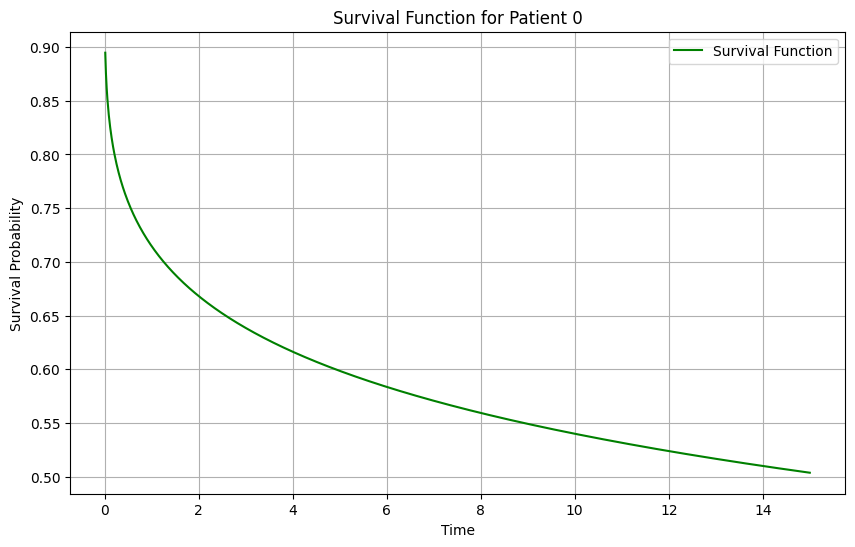

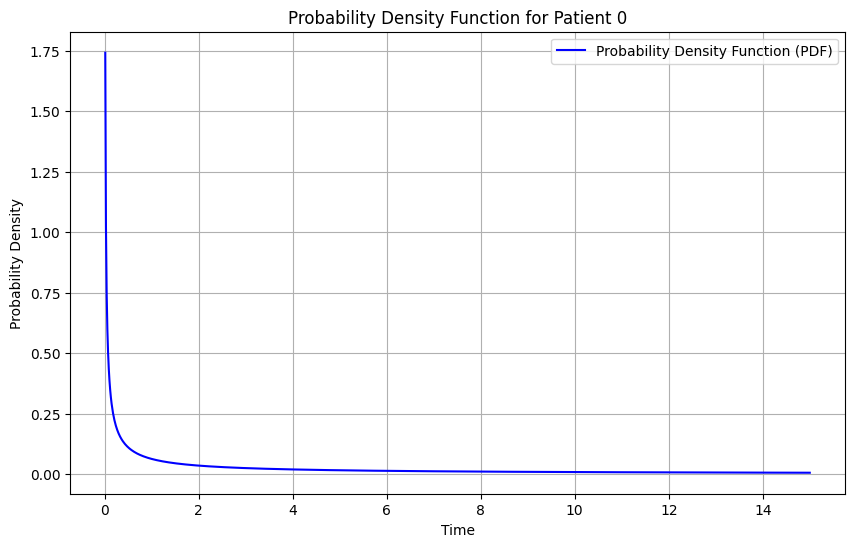

(3, 999)
--------------------------------------------------
Showing survival function and PDF for patient 1
Mean time to survival (numerical): 1.2883464291634508, (theoretical) [4.83573824e+07 3.37706473e+08 1.40064685e+08]
True times [array([6.6778009, 6.6778009, 6.6778009])]
--------------------------------------------------


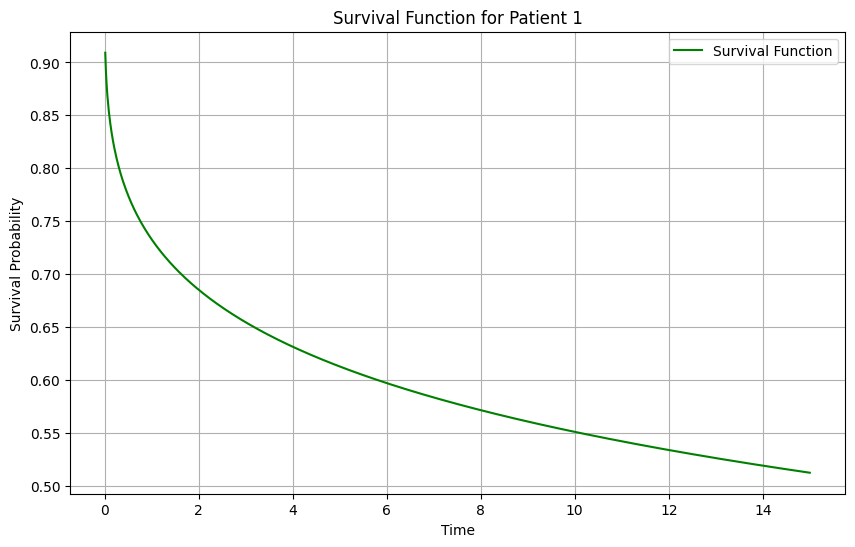

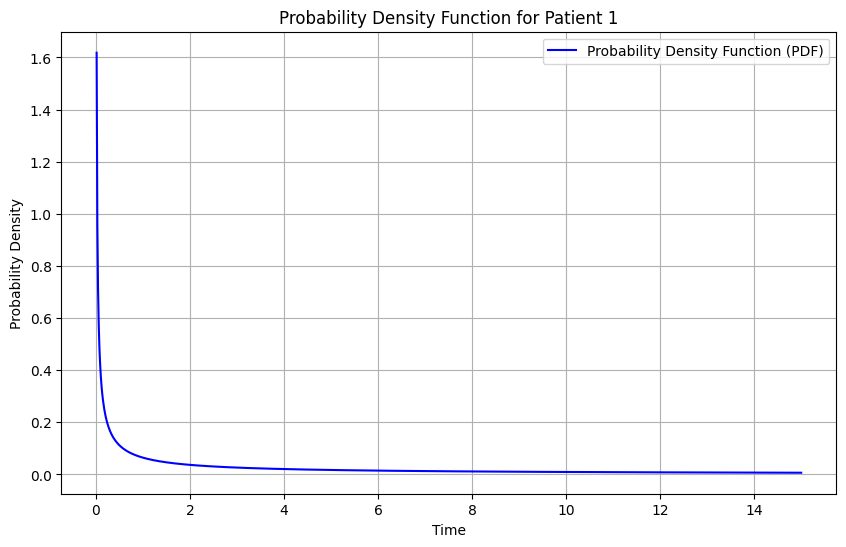

In [185]:
time_points = np.linspace(0, 15, 1000).tolist()
for i in range(2):
    patient_num = i
    patient_data = x_test[patient_num]
    patient_times = t_test[patient_num:patient_num+1].tolist()
    plot_survival_and_pdf(drsm_model, patient_data[np.newaxis, :, :], patient_times, time_points, patient_num=patient_num)

In [184]:
x_test[1]

array([[ 5.74143029,  0.        ,  0.        ,  1.73480403, -0.40386965,
         0.65641171,  0.09525416,  0.        ,  0.        ,  1.        ,
         3.        ,  0.9846716 , -0.60723234, -0.46029622, -0.29579558,
         1.        ],
       [ 6.11652612,  0.        ,  0.        ,  1.73480403, -0.44212649,
         0.25872274, -0.24042292,  0.        ,  0.        ,  1.        ,
         3.        ,  0.97423179, -0.67486874, -0.47891406,  0.        ,
         0.        ],
       [ 6.6778009 ,  0.        ,  0.        ,  1.73480403, -0.12076902,
        -0.07931288, -0.38914062,  0.        ,  0.        ,  1.        ,
         3.        ,  0.86983368, -0.67486874, -0.47891406, -0.58786896,
         1.        ]])

In [ ]:
def convert_pbc_to_panel_format(df):
    x_list, t_list, e_list = [], [], []

    for pid in sorted(df["seq_id"].unique()):
        df_patient = df[df["seq_id"] == pid].copy()

        x_arr = df_patient.drop(columns=["seq_out_time_to_event", "seq_out_event", "seq_id"]).values
        t_arr = df_patient["seq_out_time_to_event"].values
        e_arr = df_patient["seq_out_event"].values

        x_list.append(x_arr)
        t_list.append(t_arr)
        e_list.append(e_arr)

    return (
        np.array(x_list, dtype=object),
        np.array(t_list, dtype=object),
        np.array(e_list, dtype=object),
    )

def predict_pdfs(model, x, time_points):
    pdfs = []
    for i in range(len(x)):
        patient_data = x[i]
        pdf = model.predict_pdf(patient_data[np.newaxis, :, :], time_points)
        pdfs.append(pdf)
    return pdfs

def sample_times_from_pdfs(pdfs, time_grid, n_samples=1):
    time_grid = np.array(time_grid)
    sampled_times = []

    for pdf in pdfs:
        pdf = pdf[0]
        pdf = np.maximum(pdf, 0)
        pdf /= np.sum(pdf)

        samples = np.random.choice(time_grid, size=n_samples, p=pdf)
        sampled_times.append(samples)

    return np.array(sampled_times).flatten()

In [ ]:
df_synth = pd.read_csv(SYNTHETIC_DATA_PATH)
x_synth_panel, _, _ = convert_pbc_to_panel_format(df_synth)
time_grid = np.linspace(0, 15, 1000).tolist()[1:]
pdfs = predict_pdfs(drsm_model, x_synth_panel, time_grid)
sampled_times = sample_times_from_pdfs(pdfs, time_grid, n_samples=1)

In [228]:
def simulate_censoring(event_times, trial_end_time, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n = len(event_times)
    
    arrival_times = np.random.uniform(0, trial_end_time, size=n)
    
    remaining_time = trial_end_time - arrival_times
    
    E = (event_times <= remaining_time).astype(int)  # 1 if event before trial ends, else 0
    
    T = np.where(E == 1, event_times, remaining_time)

    return T, E

def expand_to_panel_format(X, T, E):
    E_panel = []
    T_panel = []

    for i in range(len(X)):
        num_timepoints = X[i].shape[0]
        e_i = np.full(num_timepoints, E[i])
        t_i = np.full(num_timepoints, T[i])
        E_panel.append(e_i)
        T_panel.append(t_i)

    return np.array(T_panel, dtype=object), np.array(E_panel, dtype=object),

def get_percent_censored(E):
    return 1 - sum(E)/len(E)

In [ ]:
trial_end_time = 5
t_synth, e_synth = simulate_censoring(sampled_times, trial_end_time)
t_synth_panel, e_synth_panel = expand_to_panel_format(x_synth_panel, t_synth, e_synth)
print(f"Percent censored: {get_percent_censored(e_synth)*100:.2f}%")

Percent censored: 40.40%


In [230]:
def split_pbc_synth_panel_format(X, T, E):
    x_train, t_train, e_train = X[:TRAIN_SYNTH_ID_CUTOFF], T[:TRAIN_SYNTH_ID_CUTOFF], E[:TRAIN_SYNTH_ID_CUTOFF]
    x_val,   t_val,   e_val   = X[TRAIN_SYNTH_ID_CUTOFF:], T[TRAIN_SYNTH_ID_CUTOFF:], E[TRAIN_SYNTH_ID_CUTOFF:]
   
    return (x_train, t_train, e_train), (x_val, t_val, e_val)

In [ ]:
(x_synth_train, t_synth_train, e_synth_train), (x_synth_val, t_synth_val, e_synth_val) = split_pbc_synth_panel_format(x_synth_panel, t_synth_panel, e_synth_panel)

print("Training new DRSM model on synthetic data...")
drsm_synth_model = DeepRecurrentSurvivalMachines(k = K,
                                distribution = DISTRIBUTION,
                                hidden = HIDDEN, 
                                typ = TYPE,
                                layers = LAYERS)
    
drsm_synth_model.fit(x_synth_train, t_synth_train, e_synth_train, iters = 1, learning_rate = LR)
nll = drsm_synth_model.compute_nll(x_synth_val, t_synth_val, e_synth_val)
print(f"Validation NLL: {nll}")
with open(MODEL_SYNTH_OUTPUT_PATH, "wb") as f:
    pickle.dump(drsm_synth_model, f)
print(f"Model saved to {MODEL_SYNTH_OUTPUT_PATH}")

Training new DRSM model on synthetic data...


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Validation NLL: 1.0077580705751001
Model saved to ../models/drsm_pbc_synthetic_model.pkl


In [287]:
horizons = [0.25, 0.5, 0.75]
test_time_horizons = np.quantile([t_[-1] for t_, e_ in zip(t_test, e_test) if e_[-1] == 1], horizons).tolist()
out_risk = drsm_synth_model.predict_risk(x_test, test_time_horizons)
out_survival = drsm_synth_model.predict_survival(x_test, test_time_horizons)

cis = []
brs = []

et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i][j], t_val[i][j]) for i in range(len(e_val)) for j in range(len(e_val[i]))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(test_time_horizons):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, test_time_horizons)[1])
roc_auc = []
for i, _ in enumerate(test_time_horizons):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")
    print(brs[0])

For 0.25 quantile,
TD Concordance Index: 0.4043062200956938
Brier Score: 0.06524802480928914
ROC AUC  0.4032258064516129 

[0.06524802 0.15124773 0.30547736]
For 0.5 quantile,
TD Concordance Index: 0.21326738434681408
Brier Score: 0.15124773222963903
ROC AUC  0.2211111111111111 

[0.06524802 0.15124773 0.30547736]
For 0.75 quantile,
TD Concordance Index: 0.28630166630599435
Brier Score: 0.3054773625756764
ROC AUC  0.2709715177526336 

[0.06524802 0.15124773 0.30547736]


In [259]:
feature_columns = ['seq_time_id',
 'seq_static_sex',
 'seq_static_drug',
 'seq_static_age',
 'seq_temporal_SGOT',
 'seq_temporal_albumin',
 'seq_temporal_alkaline',
 'seq_temporal_ascites',
 'seq_temporal_edema',
 'seq_temporal_hepatomegaly',
 'seq_temporal_histologic',
 'seq_temporal_platelets',
 'seq_temporal_prothrombin',
 'seq_temporal_serBilir',
 'seq_temporal_serChol',
 'seq_temporal_spiders'
 ]

def save_panel_data_to_csv(x_synth_seq, T_panel, E_panel, csv_path, feature_columns):
    all_rows = []

    for i in range(len(x_synth_seq)):
        x_i = x_synth_seq[i]
        t_i = T_panel[i]
        e_i = E_panel[i]
        T_i = x_i.shape[0]

        # Build dataframe per patient
        df_i = pd.DataFrame(x_i, columns=feature_columns)
        df_i["seq_id"] = i
        df_i["seq_out_time_to_event"] = t_i
        df_i["seq_out_event"] = e_i

        all_rows.append(df_i)

    df_full = pd.concat(all_rows, ignore_index=True)
    cols = df_full.columns.tolist()
    cols.remove("seq_id")
    cols = ["seq_id"] + cols
    df_full = df_full[cols]

    df_full.to_csv(csv_path, index=False)
    print(f"Saved synthetic panel-format data to {csv_path}")
    return df_full


In [260]:
save_panel_data_to_csv(x_synth_panel, t_synth_panel, e_synth_panel, SYNTHETIC_DATA_PATH_WITH_TIMES, feature_columns)

Saved synthetic panel-format data to ../data/pbc_synthetic/synthetic_pbc_data_with_times.csv


,seq_id,seq_time_id,seq_static_sex,seq_static_drug,seq_static_age,seq_temporal_SGOT,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_ascites,seq_temporal_edema,seq_temporal_hepatomegaly,seq_temporal_histologic,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_temporal_spiders,seq_out_time_to_event,seq_out_event
0,0,14.305662,0.0,0.0,-2.484082,0.330936,-0.488527,-0.480980,0.0,0.0,1.0,3.0,-1.201498,0.314828,-0.527137,-0.491646,1.0,0.495495,1
1,0,14.305662,0.0,0.0,-2.484082,-0.000591,0.000701,0.002833,0.0,0.0,0.0,3.0,0.597502,-0.000168,-0.002295,0.002247,0.0,0.495495,1
2,0,14.305662,0.0,0.0,-2.484082,-0.000768,-0.002643,-0.000835,0.0,0.0,0.0,0.0,-0.000478,0.004539,-0.508739,0.001902,0.0,0.495495,1
3,0,14.305662,0.0,0.0,-2.484082,0.002596,-0.000671,0.001678,0.0,0.0,0.0,0.0,0.001966,-0.001208,0.004148,0.002241,0.0,0.495495,1
4,1,14.305662,0.0,0.0,-1.817768,0.326259,-0.486246,-0.479428,0.0,0.0,1.0,3.0,-1.200206,0.313417,-0.528217,-0.492953,0.0,2.387387,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,499,14.305662,1.0,1.0,-1.976913,-0.341317,-0.509990,-0.483802,0.0,0.0,1.0,3.0,-0.464707,-0.178109,-0.494125,0.006823,0.0,3.078078,1
2498,499,14.305662,1.0,1.0,-1.976913,-0.379985,-0.002769,-0.535346,0.0,0.0,1.0,3.0,-0.472254,-0.606955,-0.526974,0.004033,0.0,3.078078,1
2499,499,14.305662,1.0,1.0,-1.976913,-0.464478,0.279870,-0.108589,0.0,0.0,0.0,0.0,0.336387,-0.802608,-0.473674,0.001873,0.0,3.078078,1
2500,499,14.305662,1.0,1.0,-1.976913,0.003976,0.003961,0.002266,0.0,0.0,0.0,2.0,-0.459215,-0.005754,-0.495361,0.001094,0.0,3.078078,1


In [274]:
import json
import numpy as np
import pickle
from collections import defaultdict
from copy import deepcopy

def run_censoring_experiment(
    trial_lengths,
    n_repeats,
    sampled_times,
    x_synth_panel,
    x_test,
    t_test,
    e_test,
    model_hyperparams,
    horizons,
    model_output_prefix,
    result_json_path
):
    results = []


    for trial_end_time in trial_lengths:
        for run in range(n_repeats):
            seed = 42 + run
            t_synth, e_synth = simulate_censoring(sampled_times, trial_end_time, seed=seed)
            t_synth_panel, e_synth_panel = expand_to_panel_format(x_synth_panel, t_synth, e_synth)
            # Recompute test_time_horizons on each run
            uncensored_times = [t_[-1] for t_, e_ in zip(t_synth_panel, e_synth_panel) if e_[-1] == 1]
            if len(uncensored_times) == 0:
                print(f"No uncensored patients in test set for trial={trial_end_time}, run={run}. Skipping.")
                continue

            raw_horizons = np.quantile(uncensored_times, horizons).tolist()
            max_uncensored = max(uncensored_times)
            test_time_horizons = [t for t in raw_horizons if t < max_uncensored]

            if len(test_time_horizons) == 0:
                print(f"No valid test time horizons after clipping for trial={trial_end_time}, run={run}. Skipping.")
                continue

            print(f"Percent censored: {get_percent_censored(e_synth)*100:.2f}% for trial={trial_end_time}, run={run}")

            # Split train/val
            (x_train, t_train, e_train), (x_val, t_val, e_val) = split_pbc_synth_panel_format(
                x_synth_panel, t_synth_panel, e_synth_panel
            )

            # Train model
            lr = model_hyperparams["learning_rate"]
            model_args = {k: v for k, v in model_hyperparams.items() if k != "learning_rate"}

            model = DeepRecurrentSurvivalMachines(**model_args)
            model.fit(x_train, t_train, e_train, iters=1, learning_rate=lr)
            val_nll = model.compute_nll(x_val, t_val, e_val)

            # Save model
            model_path = f"{model_output_prefix}_trial{trial_end_time}_run{run}.pkl"
            os.makedirs(os.path.dirname(model_path), exist_ok=True)

            with open(model_path, "wb") as f:
                pickle.dump(model, f)

            # Evaluate
            out_risk = model.predict_risk(x_test, test_time_horizons)
            out_survival = model.predict_survival(x_test, test_time_horizons)

            et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                                dtype=[('e', bool), ('t', float)])
            et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                               dtype=[('e', bool), ('t', float)])

            cis = [concordance_index_ipcw(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0]
                   for i in range(len(test_time_horizons))]
            brs = brier_score(et_train, et_test, out_survival, test_time_horizons)[1]
            roc_auc = [cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], test_time_horizons[i])[0]
                       for i in range(len(test_time_horizons))]

            censoring_rate = 1.0 - np.mean(e_synth)

            results.append({
                "trial_end_time": trial_end_time,
                "seed": seed,
                "val_nll": val_nll,
                "censoring_rate": censoring_rate,
                "c_index": cis,
                "brier_score": brs[0],
                "roc_auc": [auc[0] for auc in roc_auc]
            })


            print(f"trial={trial_end_time}, run={run}, censoring={censoring_rate:.2%}, NLL={val_nll:.4f}")
            
    os.makedirs(os.path.dirname(result_json_path), exist_ok=True)
    with open(result_json_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"\n📄 Saved all results to {result_json_path}")


In [275]:
run_censoring_experiment(
    trial_lengths=[5, 6, 8, 10, 12, 14],
    n_repeats=3,
    sampled_times=sampled_times,
    x_synth_panel=x_synth_panel,
    x_test=x_test,
    t_test=t_test,
    e_test=e_test,
    model_hyperparams={
        "k": 3,
        "distribution": "Weibull",
        "hidden": 50,
        "typ": "RNN",
        "layers": 1,
        "learning_rate": 1e-3
    },
    horizons=[0.25, 0.5, 0.75],
    model_output_prefix="../models/experiments/drsm_synth",
    result_json_path="../results/censoring_sweep.json"
)


Percent censored: 42.60% for trial=5, run=0


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 26.90it/s]


trial=5, run=0, censoring=42.60%, NLL=0.7954
Percent censored: 44.40% for trial=5, run=1


100%|██████████| 1/1 [00:00<00:00, 30.07it/s]


trial=5, run=1, censoring=44.40%, NLL=0.8032
Percent censored: 41.60% for trial=5, run=2


100%|██████████| 1/1 [00:00<00:00, 34.09it/s]


trial=5, run=2, censoring=41.60%, NLL=0.9243
Percent censored: 38.00% for trial=6, run=0


100%|██████████| 1/1 [00:00<00:00, 25.72it/s]


trial=6, run=0, censoring=38.00%, NLL=0.9103
Percent censored: 41.00% for trial=6, run=1


100%|██████████| 1/1 [00:00<00:00, 26.74it/s]


trial=6, run=1, censoring=41.00%, NLL=0.8841
Percent censored: 39.20% for trial=6, run=2


100%|██████████| 1/1 [00:00<00:00, 25.58it/s]


trial=6, run=2, censoring=39.20%, NLL=0.9687
Percent censored: 32.80% for trial=8, run=0


100%|██████████| 1/1 [00:00<00:00, 30.97it/s]


trial=8, run=0, censoring=32.80%, NLL=1.0398
Percent censored: 37.40% for trial=8, run=1


100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


trial=8, run=1, censoring=37.40%, NLL=1.0245
Percent censored: 34.00% for trial=8, run=2


100%|██████████| 1/1 [00:00<00:00, 34.16it/s]


trial=8, run=2, censoring=34.00%, NLL=1.0735
Percent censored: 30.20% for trial=10, run=0


100%|██████████| 1/1 [00:00<00:00, 25.39it/s]


trial=10, run=0, censoring=30.20%, NLL=1.1976
Percent censored: 32.80% for trial=10, run=1


100%|██████████| 1/1 [00:00<00:00, 26.57it/s]


trial=10, run=1, censoring=32.80%, NLL=1.1002
Percent censored: 28.40% for trial=10, run=2


100%|██████████| 1/1 [00:00<00:00, 34.61it/s]


trial=10, run=2, censoring=28.40%, NLL=1.2472
Percent censored: 26.20% for trial=12, run=0


100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


trial=12, run=0, censoring=26.20%, NLL=1.2623
Percent censored: 29.80% for trial=12, run=1


100%|██████████| 1/1 [00:00<00:00, 30.61it/s]


trial=12, run=1, censoring=29.80%, NLL=1.2271
Percent censored: 26.00% for trial=12, run=2


100%|██████████| 1/1 [00:00<00:00, 31.59it/s]


trial=12, run=2, censoring=26.00%, NLL=1.2880
Percent censored: 23.80% for trial=14, run=0


100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


trial=14, run=0, censoring=23.80%, NLL=1.3823
Percent censored: 25.60% for trial=14, run=1


100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


trial=14, run=1, censoring=25.60%, NLL=1.3807
Percent censored: 22.80% for trial=14, run=2


100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


trial=14, run=2, censoring=22.80%, NLL=1.3336

📄 Saved all results to ../results/censoring_sweep.json


In [277]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load JSON into a DataFrame
with open("../results/censoring_sweep.json", "r") as f:
    results = json.load(f)

df = pd.DataFrame(results)

# Flatten the nested metrics for each horizon
for i, h in enumerate(["25%", "50%", "75%"]):
    df[f"c_index_{h}"] = df["c_index"].apply(lambda x: x[i])
    df[f"roc_auc_{h}"] = df["roc_auc"].apply(lambda x: x[i])

# Drop nested columns
df = df.drop(columns=["c_index", "roc_auc"])

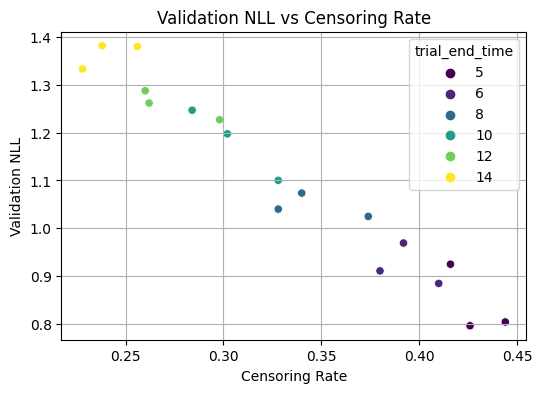

In [278]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="censoring_rate", y="val_nll", hue="trial_end_time", palette="viridis")
plt.xlabel("Censoring Rate")
plt.ylabel("Validation NLL")
plt.title("Validation NLL vs Censoring Rate")
plt.grid(True)
plt.show()

In [289]:
real_c_index_25, real_c_index_50, real_c_index_75 = 0.6196172248803827, 0.37532732033750366, 0.3929885306210777

real_auc_25, real_auc_50, real_auc_75 = 0.657258064516129, 0.38527777777777783, 0.3833398361295357

real_brier_score = 0.05091750489821231

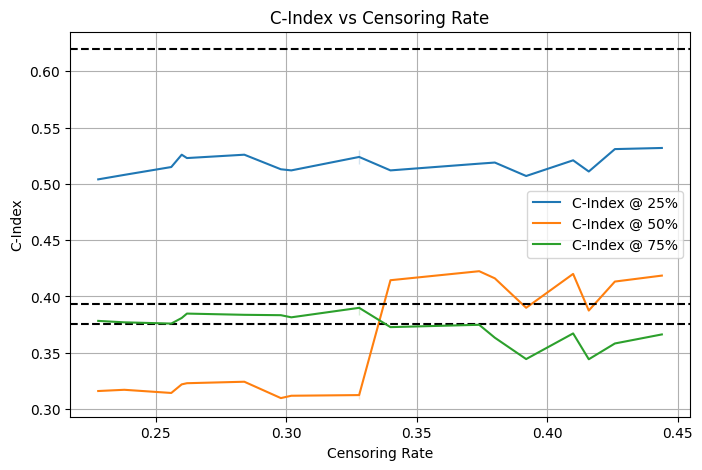

In [292]:
plt.figure(figsize=(8, 5))
real_c_indices = {"25%": real_c_index_25, "50%": real_c_index_50, "75%": real_c_index_75}

for h in ["25%", "50%", "75%"]:
    sns.lineplot(data=df, x="censoring_rate", y=f"c_index_{h}", label=f"C-Index @ {h}")
    plt.axhline(y=real_c_indices[h], linestyle="--", color="black")

plt.xlabel("Censoring Rate")
plt.ylabel("C-Index")
plt.title("C-Index vs Censoring Rate")
plt.grid(True)
plt.legend()
plt.show()

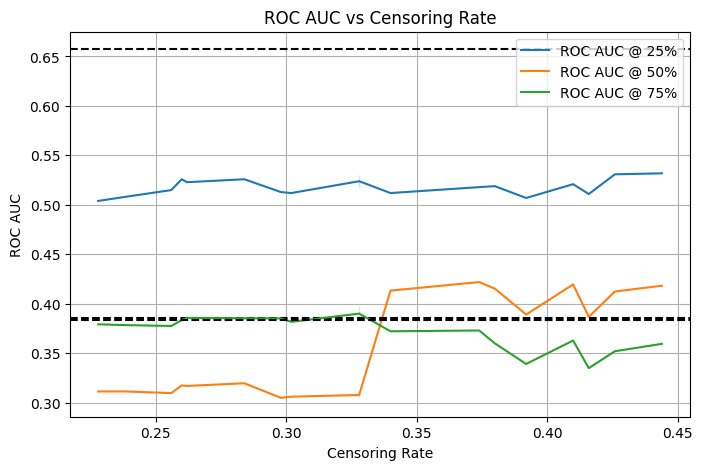

In [294]:
plt.figure(figsize=(8, 5))
real_aucs = {"25%": real_auc_25, "50%": real_auc_50, "75%": real_auc_75}

for h in ["25%", "50%", "75%"]:
    sns.lineplot(data=df, x="censoring_rate", y=f"roc_auc_{h}", label=f"ROC AUC @ {h}")
    plt.axhline(y=real_aucs[h], linestyle="--", color="black")

plt.xlabel("Censoring Rate")
plt.ylabel("ROC AUC")
plt.title("ROC AUC vs Censoring Rate")
plt.grid(True)
plt.legend()
plt.show()


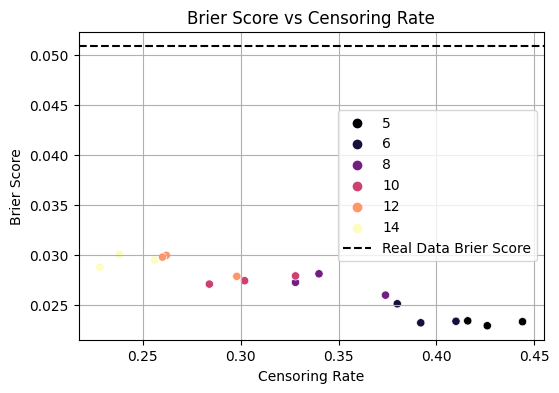

In [295]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="censoring_rate", y="brier_score", hue="trial_end_time", palette="magma")
plt.axhline(y=real_brier_score, linestyle="--", color="black", label="Real Data Brier Score")

plt.xlabel("Censoring Rate")
plt.ylabel("Brier Score")
plt.title("Brier Score vs Censoring Rate")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
x_synth_panel, t_synth_panel, e_synth_panel

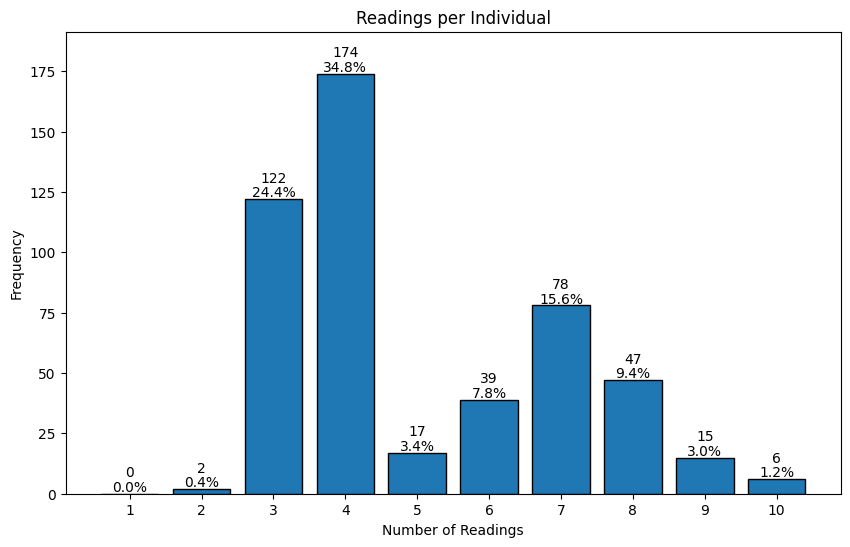

In [286]:
readings = []
n = len(x_synth_panel)
for entry in x_synth_panel:
    readings.append(entry.shape[0])

bins = np.arange(1, max(readings)+2)

plt.figure(figsize=(10, 6))
counts, _, _ = plt.hist(readings, bins=bins, edgecolor='black', align='left', rwidth=0.8)
plt.ylim(0, max(counts) * 1.1)

plt.xlabel("Number of Readings")
plt.ylabel("Frequency")
plt.title("Readings per Individual")

for i in range(1, max(readings)+1):
    plt.text(i, counts[i-1] + 1, str(round(100 * counts[i-1]/n, 2)) + '%', ha='center')
    plt.text(i, counts[i-1] + 7, str(int(counts[i-1])), ha='center')

plt.xticks(np.arange(1, max(readings)+1))
plt.show()